In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

from src.models.unet.unet_model import UNet
from src.models.basic_axial.basic_axialnet import BasicAxial
from src.models.basic_pga.basic_pga_net import BasicAxialPGA
from src.datasets.ice import Ice, IceWithProposals, BasicDatasetIce
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
from src.metrics.utils import display_metric_list

import matplotlib.pyplot as plt
import time

import os

def crop_center2d(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def crop_center3d(img,cropx,cropy):
    _, y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:, starty:starty+cropy,startx:startx+cropx]

In [2]:
data_dir = '/home/dsola/repos/PGA-Net/data/'
img_scale = .35
img_crop = 320
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
#                   os.path.join(data_dir, 'txt_files'), 'test', img_scale, img_crop)
# test_loader = DataLoader(test_set, batch_size=1)
# test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
#                   os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)
# test_loader = DataLoader(test_set, batch_size=1)

dir_img = os.path.join(data_dir, 'imgs')
dir_mask = os.path.join(data_dir, 'masks')
dir_txt = os.path.join(data_dir, 'txt_files')
test_set = BasicDatasetIce(dir_img, dir_mask, dir_txt, 'test', img_scale)
test_loader = DataLoader(test_set, batch_size=batch_size,num_workers=8, pin_memory=True)

Image finished in 0.3582606315612793 seconds.
0.3582606315612793
Image finished in 0.20912551879882812 seconds.
0.5673861503601074
Image finished in 0.17270946502685547 seconds.
0.7400956153869629
Image finished in 0.2433013916015625 seconds.
0.9833970069885254
Image finished in 0.1816871166229248 seconds.
1.1650841236114502
Image finished in 0.18732404708862305 seconds.
1.3524081707000732
Image finished in 0.18000149726867676 seconds.
1.53240966796875


<ipython-input-4-7fa6ee33887a>:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,3, figsize=(15,15))


Image finished in 0.19612669944763184 seconds.
1.7285363674163818
Image finished in 0.17610502243041992 seconds.
1.9046413898468018
Image finished in 0.2717900276184082 seconds.
2.17643141746521


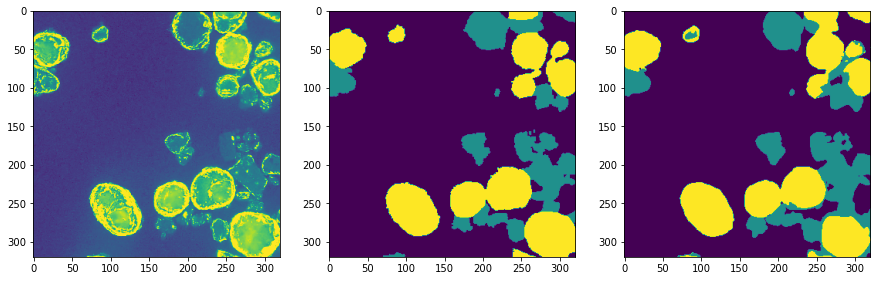

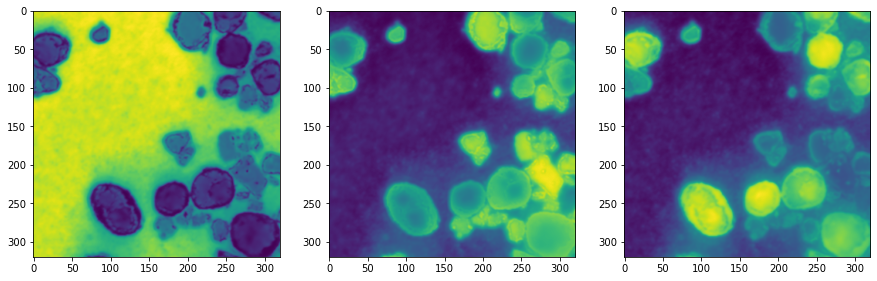

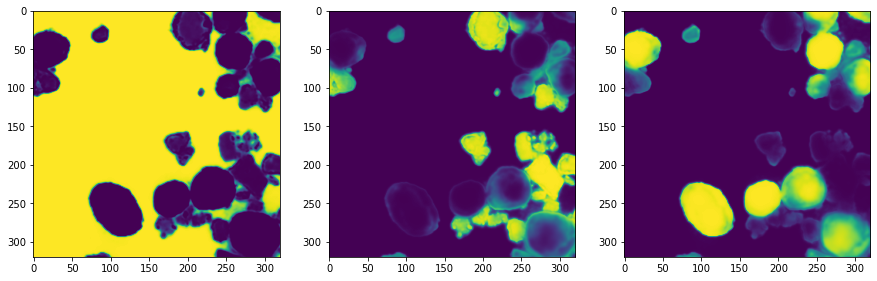

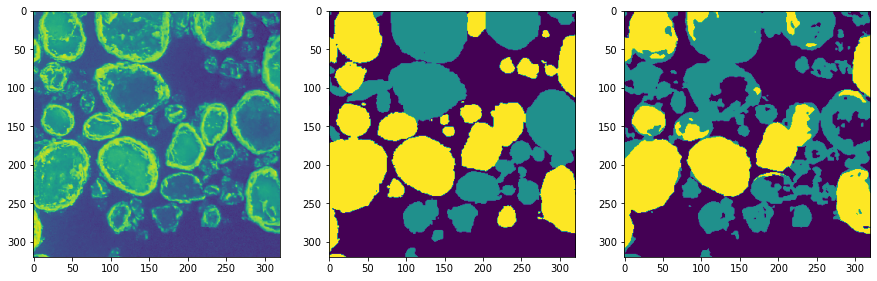

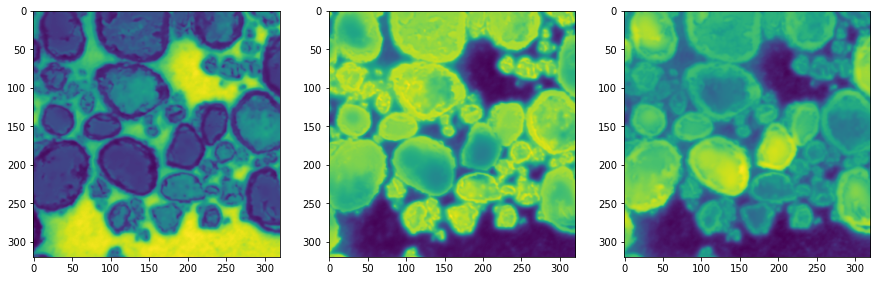

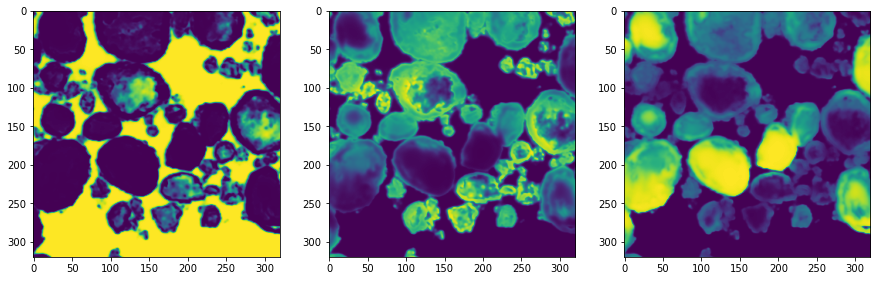

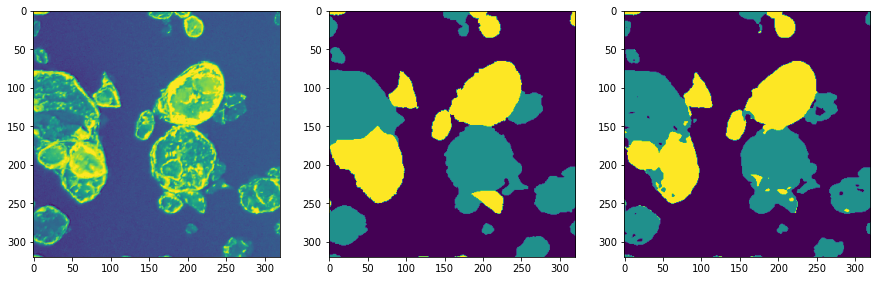

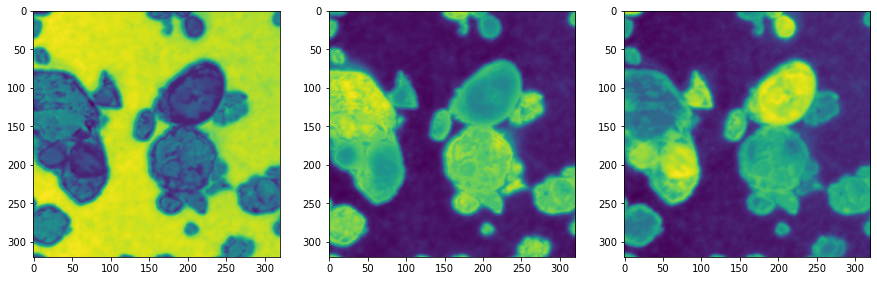

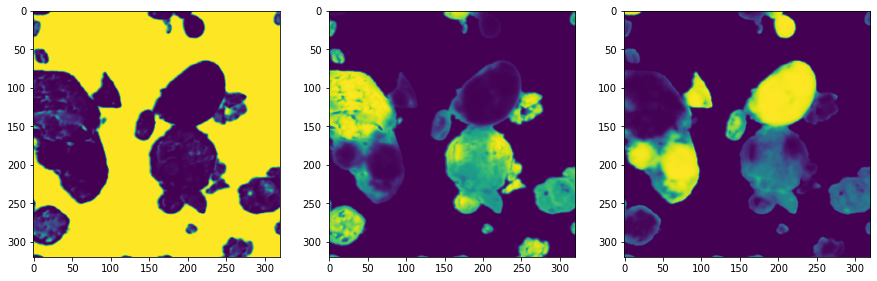

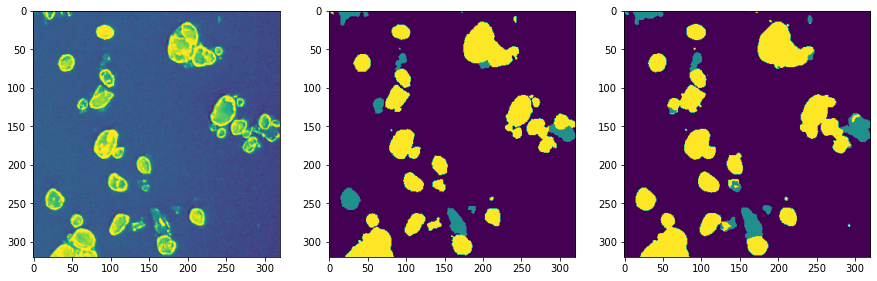

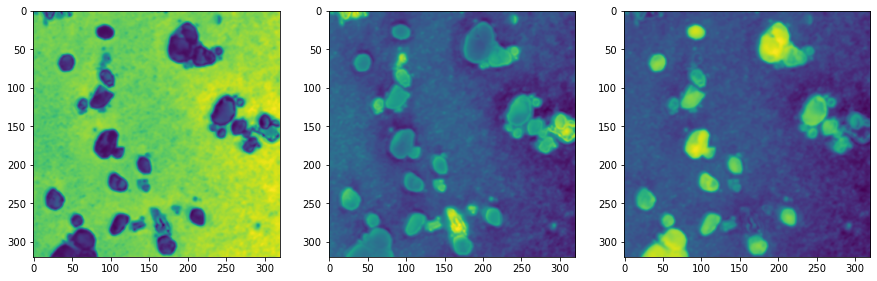

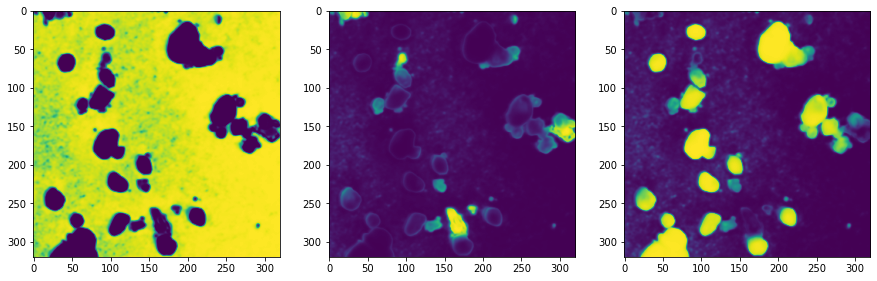

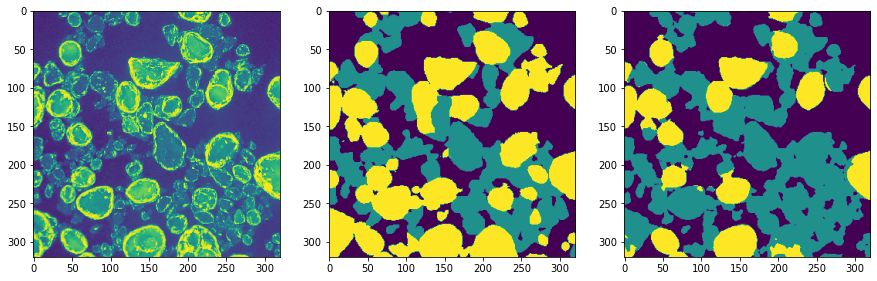

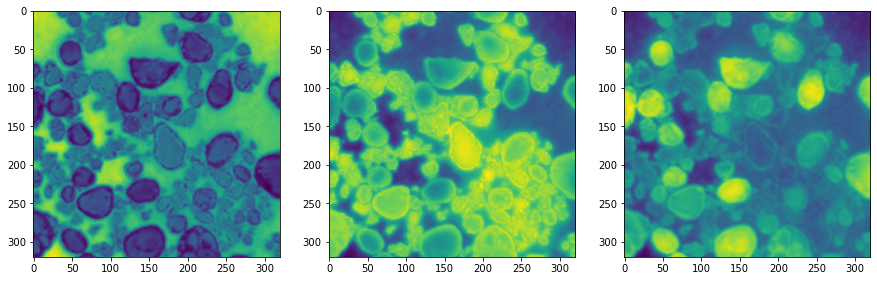

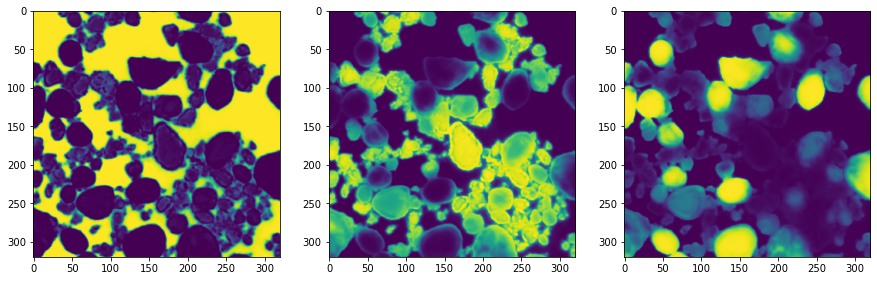

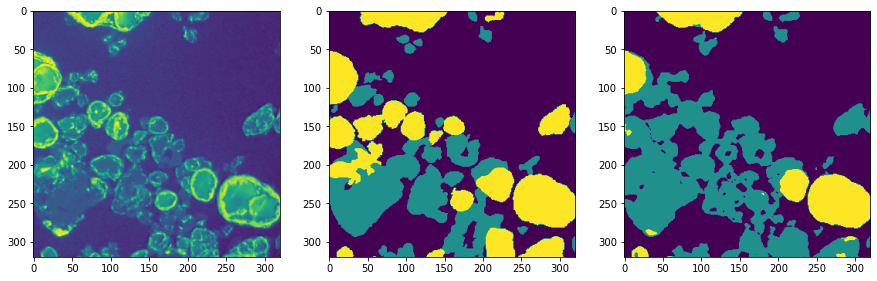

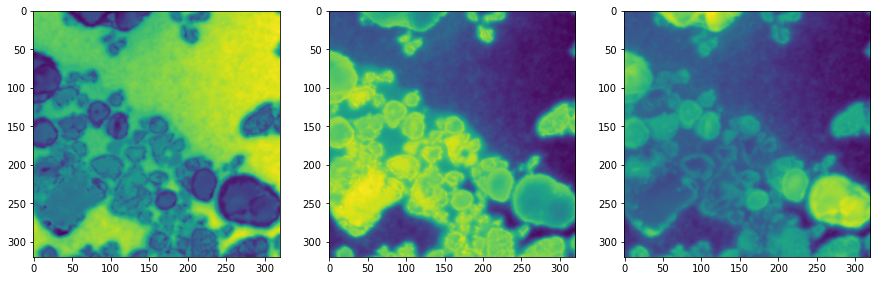

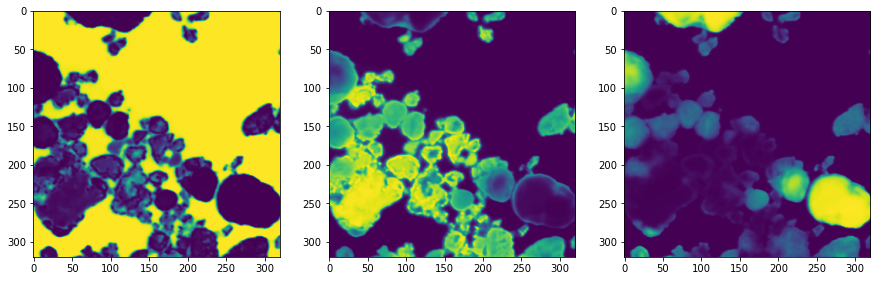

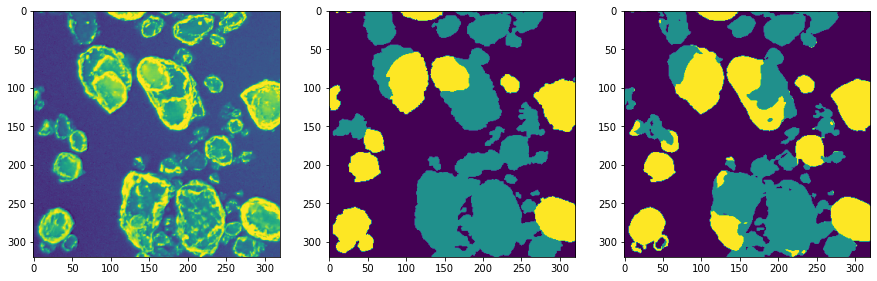

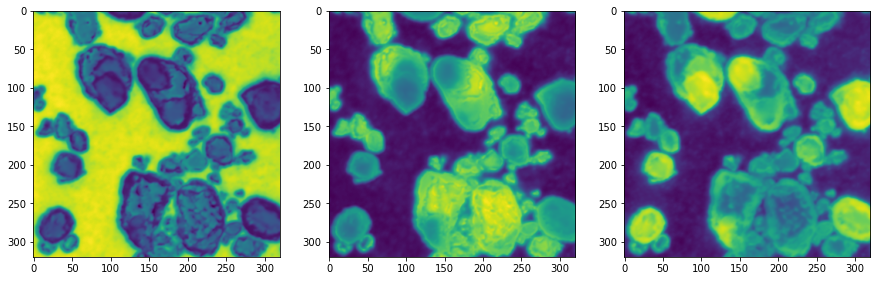

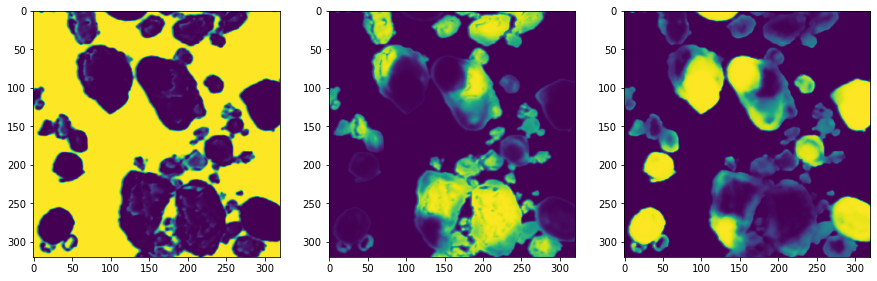

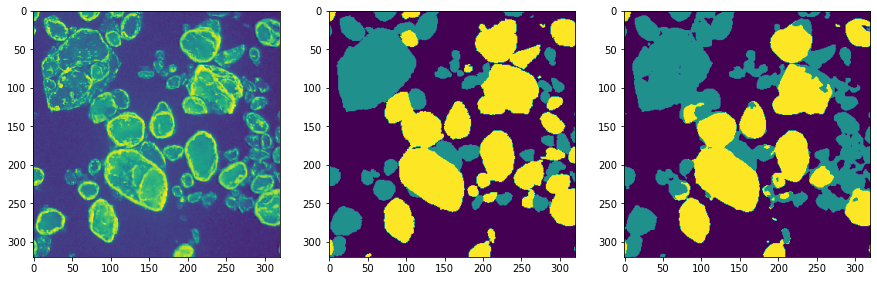

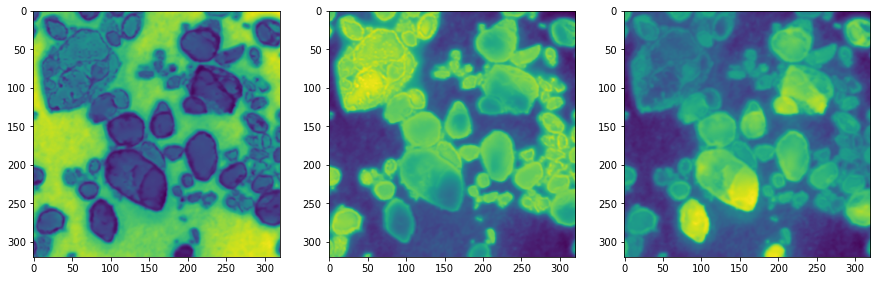

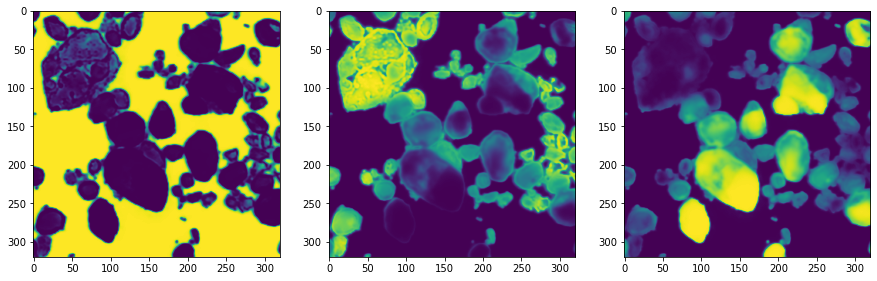

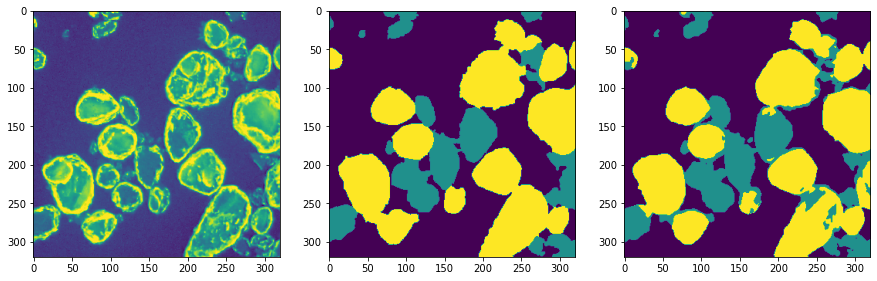

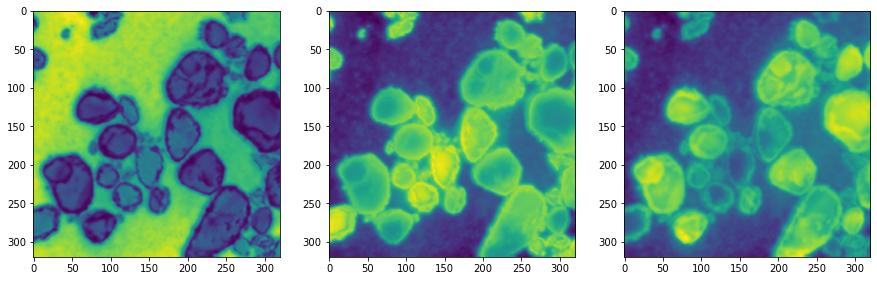

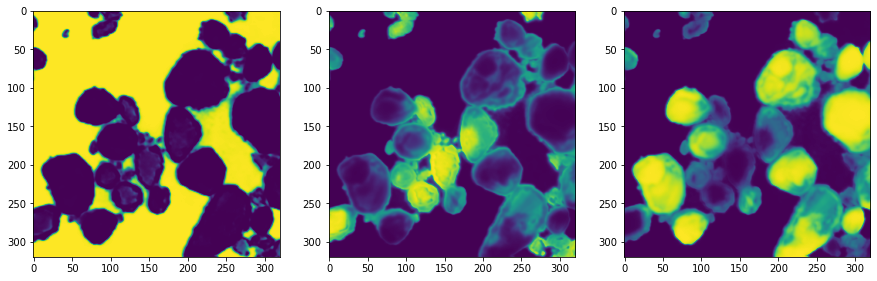

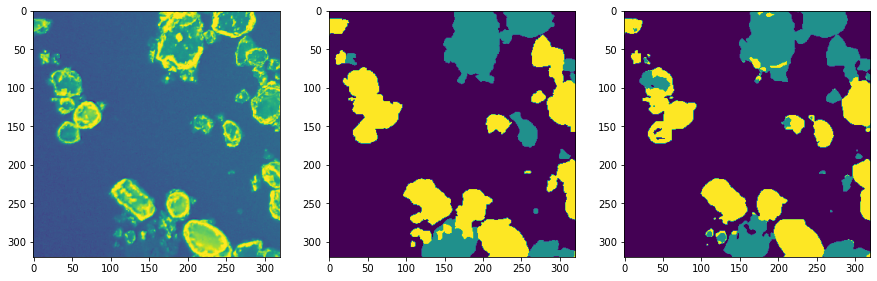

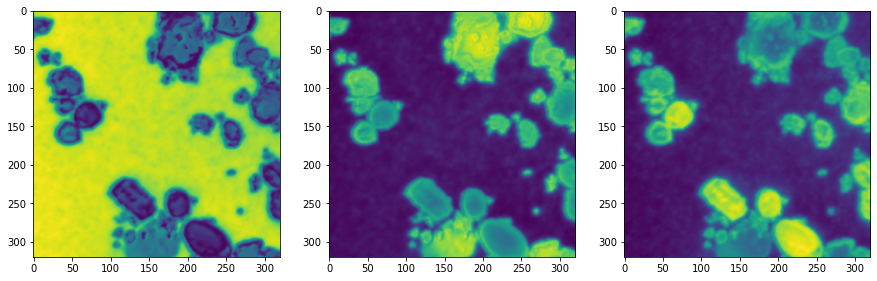

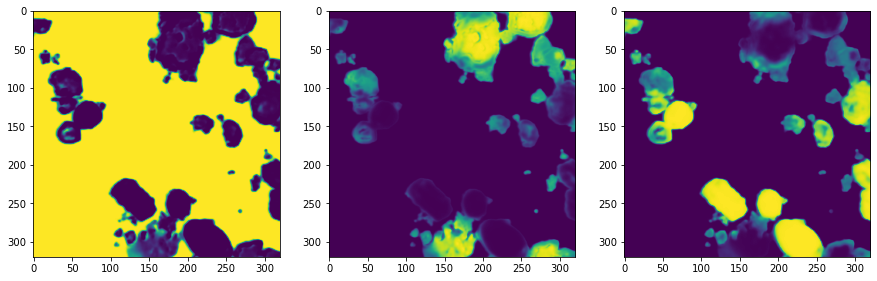

In [4]:
# model = BasicAxial(3, 3, 10, img_crop=img_crop).to(device=device)
model = UNet(n_channels=3, n_classes=3, bilinear=True).to(device=device)
criterion = nn.CrossEntropyLoss()
tot = 0

model.load_state_dict(torch.load('/home/dsola/repos/PGA-Net/checkpoints/autumn_surf_160_unet_no_scheduler/epoch20.pth', map_location=device))
model.eval()
out = nn.Softmax(dim=1)

accs, ious, losses = [], [], []

for i, batch in enumerate(test_loader):
#     print(i)
    # batch = test_set[0]
    start = time.time()
    img = batch['image'].to(device=device)
    mask = batch['mask'].to(device=device, dtype=torch.long)

    with torch.no_grad():
        output = model(img)
    
    sftmx = out(output)
    argmx = torch.argmax(sftmx, dim=1)

    hist = _fast_hist(mask.squeeze(0).squeeze(0).to(dtype=torch.long), argmx.squeeze(0).to(dtype=torch.long), 3)
    losses.append(criterion(output, mask.squeeze(1)).item())

    accs.append(per_class_pixel_accuracy(hist))
    ious.append(jaccard_index(hist))
    
    img = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
    mask = mask.squeeze(0).squeeze(0).detach().cpu().numpy()
    pred = argmx.squeeze(0).detach().cpu().numpy()
    output_c1 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
    output_c2 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
    output_c3 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]
    sftmx_c1 = sftmx.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
    sftmx_c2 = sftmx.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
    sftmx_c3 = sftmx.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]
    img = crop_center2d(img, img_crop, img_crop)
    mask = crop_center2d(mask, img_crop, img_crop)
    pred = crop_center2d(pred, img_crop, img_crop)
    output_c1 = crop_center2d(output_c1, img_crop, img_crop)
    output_c2 = crop_center2d(output_c2, img_crop, img_crop)
    output_c3 = crop_center2d(output_c3, img_crop, img_crop)
    sftmx_c1 = crop_center2d(sftmx_c1, img_crop, img_crop)
    sftmx_c2 = crop_center2d(sftmx_c2, img_crop, img_crop)
    sftmx_c3 = crop_center2d(sftmx_c3, img_crop, img_crop)
    
    fig, axs = plt.subplots(1,3, figsize=(15,15));
    axs[0].imshow(img);
    axs[1].imshow(mask);
    axs[2].imshow(pred);
    
    fig, axs = plt.subplots(1,3, figsize=(15,15))
    axs[0].imshow(output_c1);
    axs[1].imshow(output_c2);
    axs[2].imshow(output_c3);
    
    fig, axs = plt.subplots(1,3, figsize=(15,15))
    axs[0].imshow(sftmx_c1);
    axs[1].imshow(sftmx_c2);
    axs[2].imshow(sftmx_c3);
    
    end = time.time()
    tot += (end - start)
    print(f"Image finished in {end - start} seconds.")
    print(tot)

In [5]:
display_metric_list(accs, 'Accuracy')
display_metric_list(ious, 'IoU')

Mean water Accuracy: 0.9746915698051453
Mean anchor Accuracy: 0.8056795001029968
Mean frazil Accuracy: 0.7538953423500061
Mean Accuracy: 0.8447555303573608
Mean water IoU: 0.9348243474960327
Mean anchor IoU: 0.5916885137557983
Mean frazil IoU: 0.6806541085243225
Mean IoU: 0.7357223033905029


In [5]:
print(np.mean(losses))

0.2522865831851959


In [6]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

17267523


In [7]:
params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
#         print(name, param.numel())
        params += param.numel()
#         print(param)
print(params)

17267523


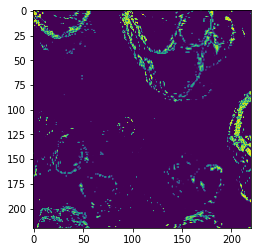

In [15]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]);

In [22]:
batch = test_set[5]
img = batch['image'].unsqueeze(0).to(device=device)
mask = batch['mask'].unsqueeze(0).to(device=device, dtype=torch.long)
prop = batch['prop'].unsqueeze(0).to(device=device, dtype=torch.long)

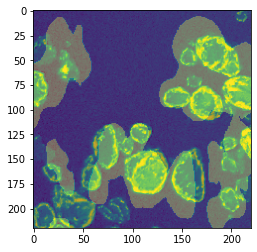

In [23]:
plt.figure()
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
plt.imshow(prop.squeeze(0).squeeze(0).detach().cpu().numpy(), alpha=0.3);

In [13]:
output[0].shape

torch.Size([3, 220, 220])

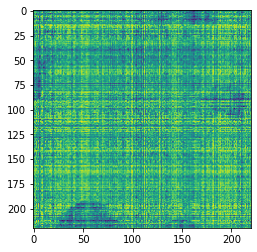

In [10]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [3]:
img = test_set[1]['image'].unsqueeze(0).to(device=device)
mask = test_set[1]['mask'].unsqueeze(0).to(device=device, dtype=torch.float32)
print(img.shape, mask.shape)

torch.Size([1, 3, 220, 220]) torch.Size([1, 1, 220, 220])


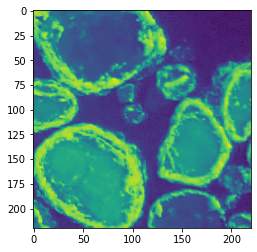

In [4]:
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

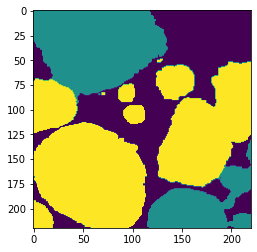

In [5]:
plt.imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());

In [6]:
model = BasicAxial(3, 3, 10, img_crop=img_crop).to(device=device)
model.load_state_dict(torch.load('../checkpoints/epoch20.pth', map_location=device))
model.eval()
output = model(img)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


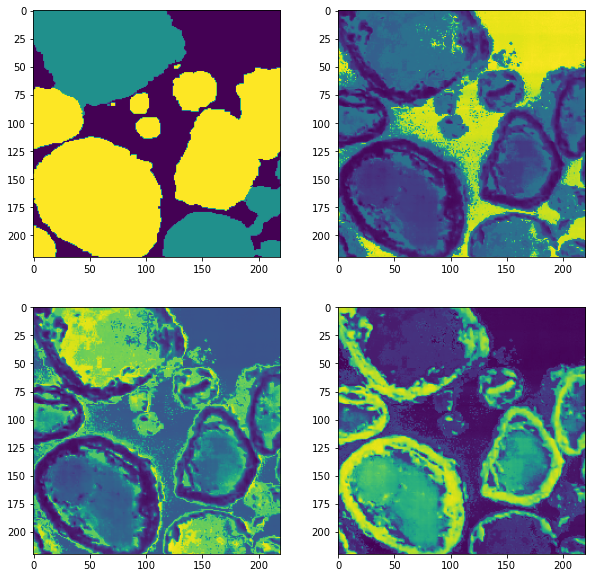

In [7]:
water = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
ice1 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
ice2 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]

fix, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy())
axs[0][1].imshow((water))
axs[1][0].imshow((ice1))
axs[1][1].imshow((ice2))

torch.Size([1, 220, 220])


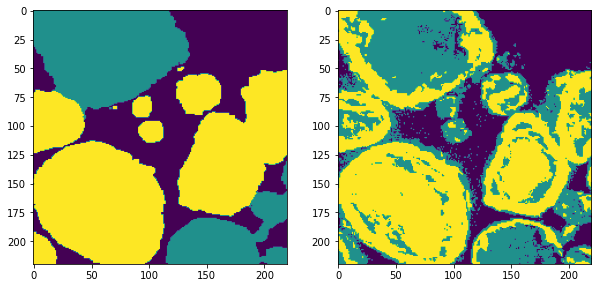

In [12]:
argmx = torch.argmax(output, dim=1)
print(argmx.shape)
fig, axs = plt.subplots(1,2, figsize=(10,10));
axs[0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());
axs[1].imshow(argmx.squeeze(0).detach().cpu().numpy());

In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

22200


In [23]:
water = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
ice1 = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
ice2 = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]

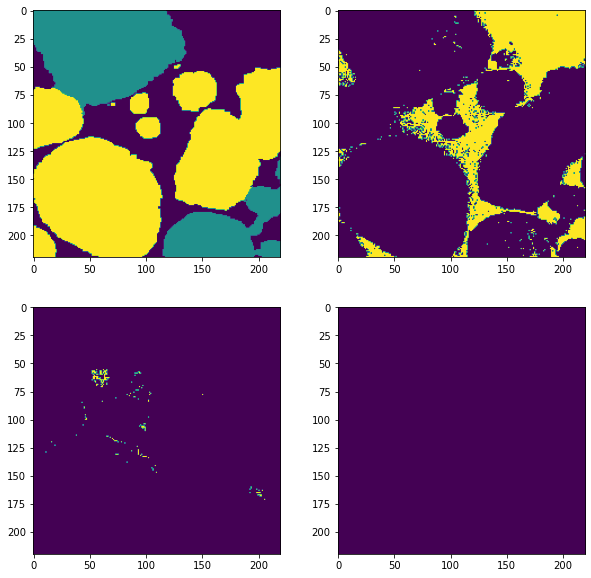

In [27]:
fix, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy())
axs[0][1].imshow((water>0.5))
axs[1][0].imshow((ice1>0.5))
axs[1][1].imshow((ice2>0.5))

In [16]:
np.unique(ice2)

array([6.1915780e-05, 8.1588587e-05, 8.1999642e-05, ..., 4.4421831e-01,
       4.4426095e-01, 4.4441947e-01], dtype=float32)